In [4]:
import torch
import gpytorch
import numpy as np
import optuna
from src.plotting import plot_gp, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ApproximateGPBaseModel
from src.hyperparameter_tuning import HyperParameterOptimization
from src.beta_likelihood import BetaLikelihood_MeanParametrization

In [5]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 3
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)

==> Loading data
==> Loaded data in: 0 m : 10 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



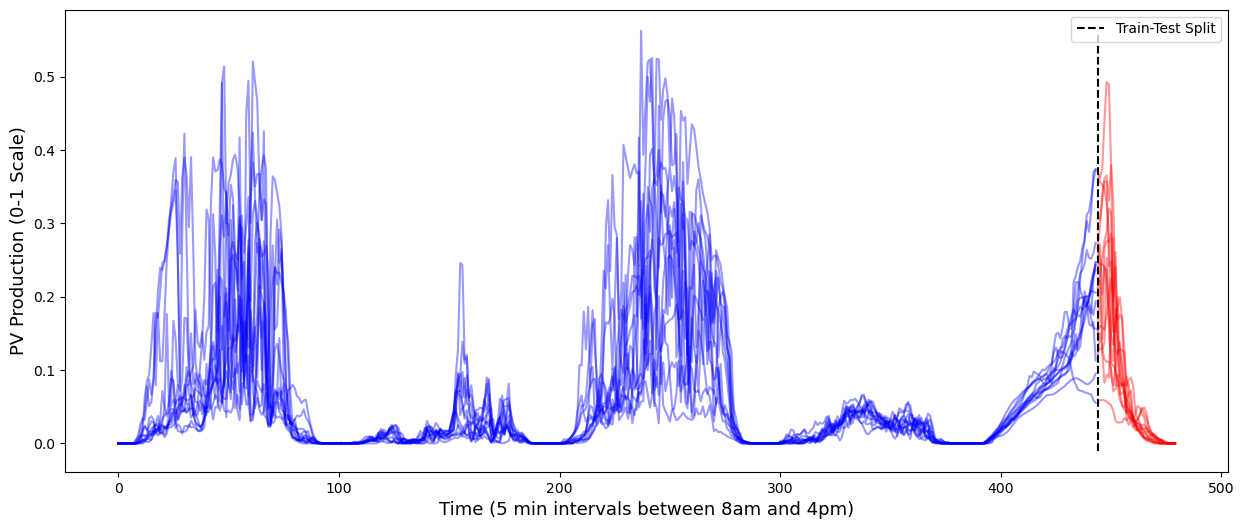

In [13]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
_, y_train, _, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [14]:
# get individual time series
y = torch.clamp(y, min=0, max=1)
# get time related variables
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
time = torch.stack([time, periodic_time], dim=1)

time[:,0] = time[:,0] / time[:,0].max()
# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=N_HOURS_PRED)

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

# Kernels

In [15]:
from gpytorch.kernels import (MaternKernel, 
                              PeriodicKernel,
                              ScaleKernel, 
                              AdditiveKernel, 
                              ProductKernel)

matern_base = MaternKernel(nu=3/2, 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                            period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_periodic = ScaleKernel(periodic,
                                outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                                outputscale_constraint=gpytorch.constraints.Positive()
                            )
scaled_matern = ScaleKernel(matern_base, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.1, 1)
                            )
product_kernel_matern_periodic = ScaleKernel(periodic * matern_base,
                             outputscale_prior = gpytorch.priors.GammaPrior(5, 2),
                             outputscale_constraint=gpytorch.constraints.Positive()
                            )

quasi_periodic_matern = AdditiveKernel(product_kernel_matern_periodic, scaled_matern)


Iter 30/300 - Loss: -2.190
Iter 60/300 - Loss: -2.651
Iter 90/300 - Loss: -2.791
Iter 120/300 - Loss: -2.869
Iter 150/300 - Loss: -2.927
Iter 180/300 - Loss: -2.969
Iter 210/300 - Loss: -2.994
Iter 240/300 - Loss: -3.009
Iter 270/300 - Loss: -3.021
Iter 300/300 - Loss: -3.029


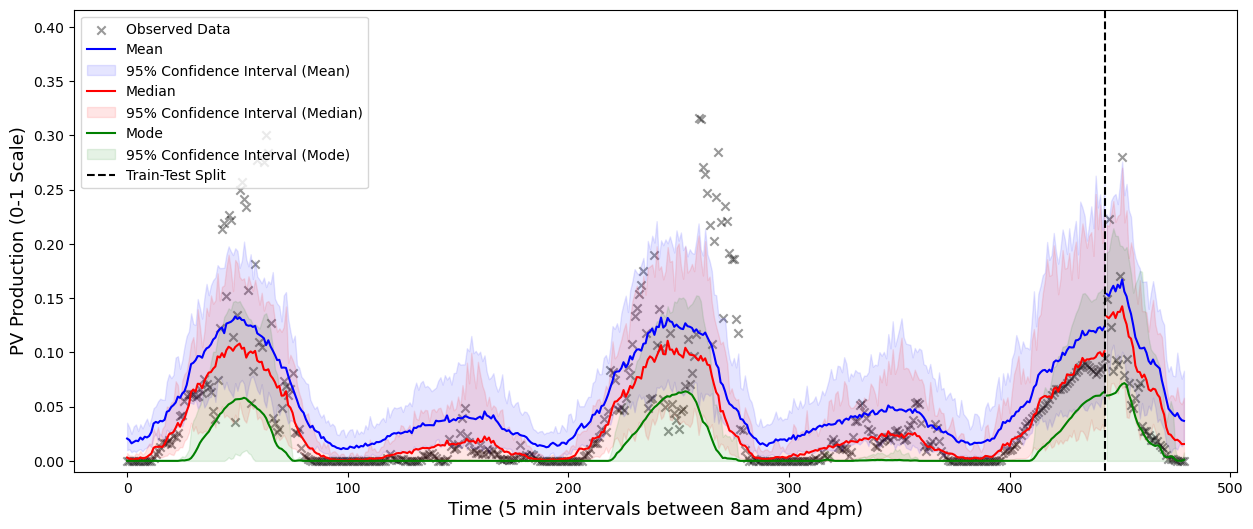

Iter 30/300 - Loss: -1.952
Iter 60/300 - Loss: -2.472
Iter 90/300 - Loss: -2.612
Iter 120/300 - Loss: -2.678
Iter 150/300 - Loss: -2.719
Iter 180/300 - Loss: -2.747
Iter 210/300 - Loss: -2.767
Iter 240/300 - Loss: -2.784
Iter 270/300 - Loss: -2.797
Iter 300/300 - Loss: -2.809


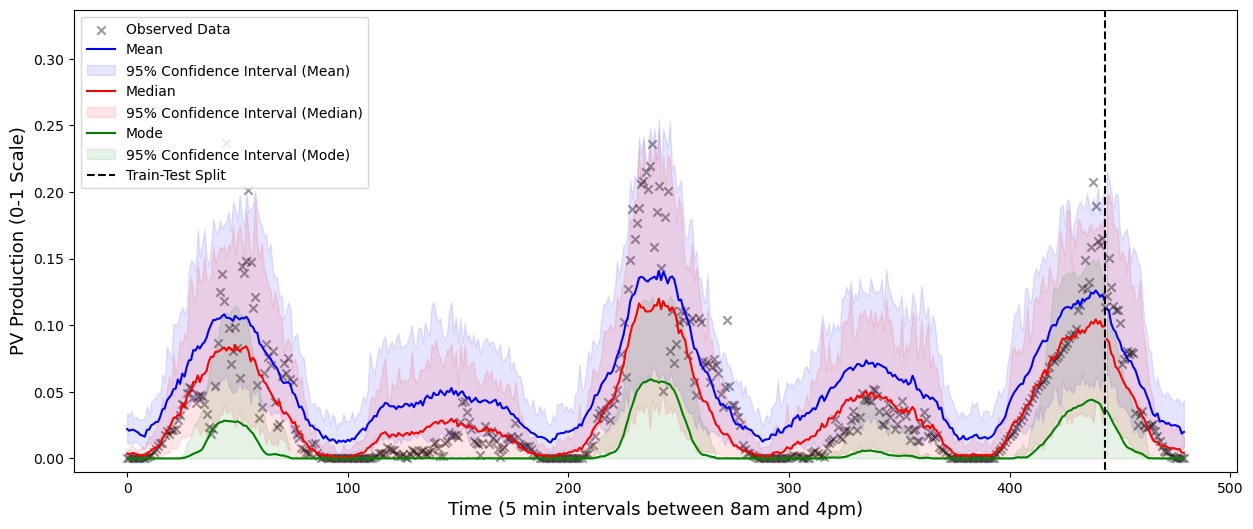

Iter 30/300 - Loss: -1.784
Iter 60/300 - Loss: -2.330
Iter 90/300 - Loss: -2.501
Iter 120/300 - Loss: -2.573
Iter 150/300 - Loss: -2.613
Iter 180/300 - Loss: -2.639
Iter 210/300 - Loss: -2.659
Iter 240/300 - Loss: -2.675
Iter 270/300 - Loss: -2.688
Iter 300/300 - Loss: -2.699


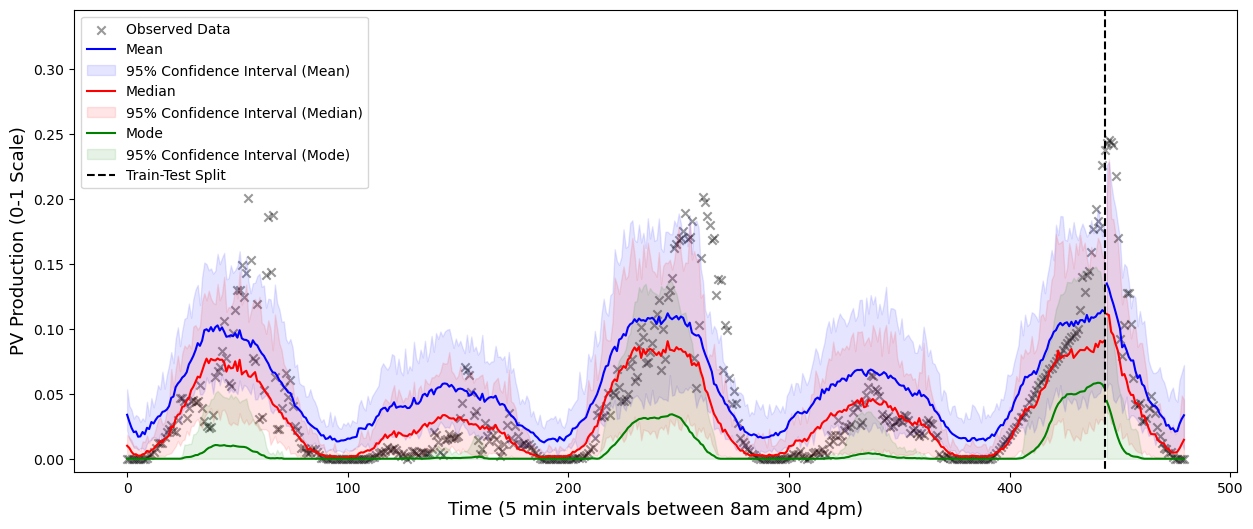

Iter 30/300 - Loss: -1.796
Iter 60/300 - Loss: -2.231
Iter 90/300 - Loss: -2.391
Iter 120/300 - Loss: -2.456
Iter 150/300 - Loss: -2.490
Iter 180/300 - Loss: -2.513
Iter 210/300 - Loss: -2.532
Iter 240/300 - Loss: -2.546
Iter 270/300 - Loss: -2.556
Iter 300/300 - Loss: -2.565


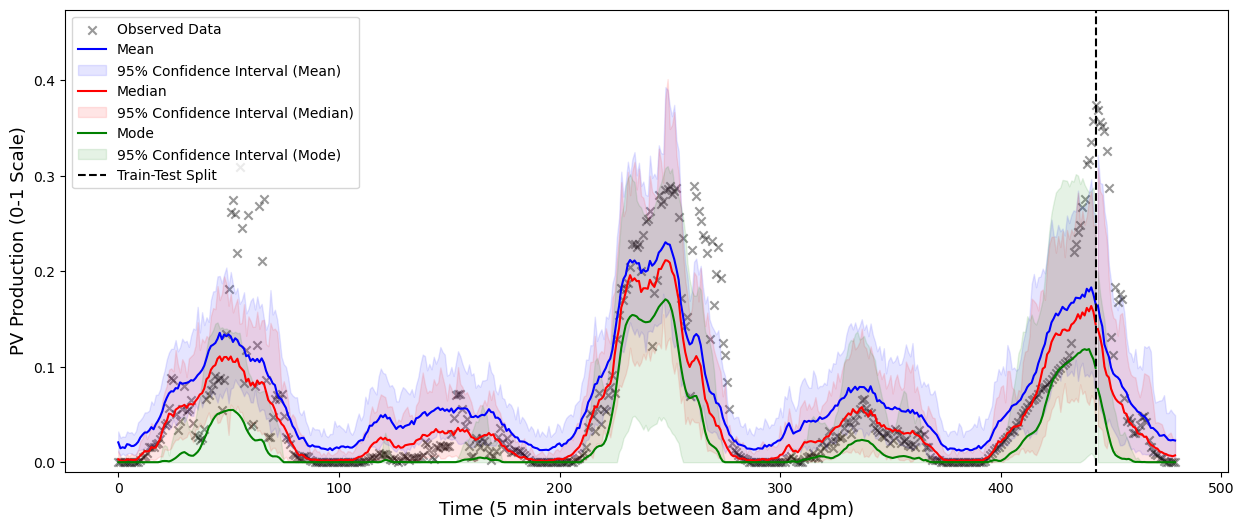

Iter 30/300 - Loss: -1.423
Iter 60/300 - Loss: -2.009
Iter 90/300 - Loss: -2.158
Iter 120/300 - Loss: -2.232
Iter 150/300 - Loss: -2.272
Iter 180/300 - Loss: -2.292
Iter 210/300 - Loss: -2.305
Iter 240/300 - Loss: -2.314
Iter 270/300 - Loss: -2.321
Iter 300/300 - Loss: -2.326


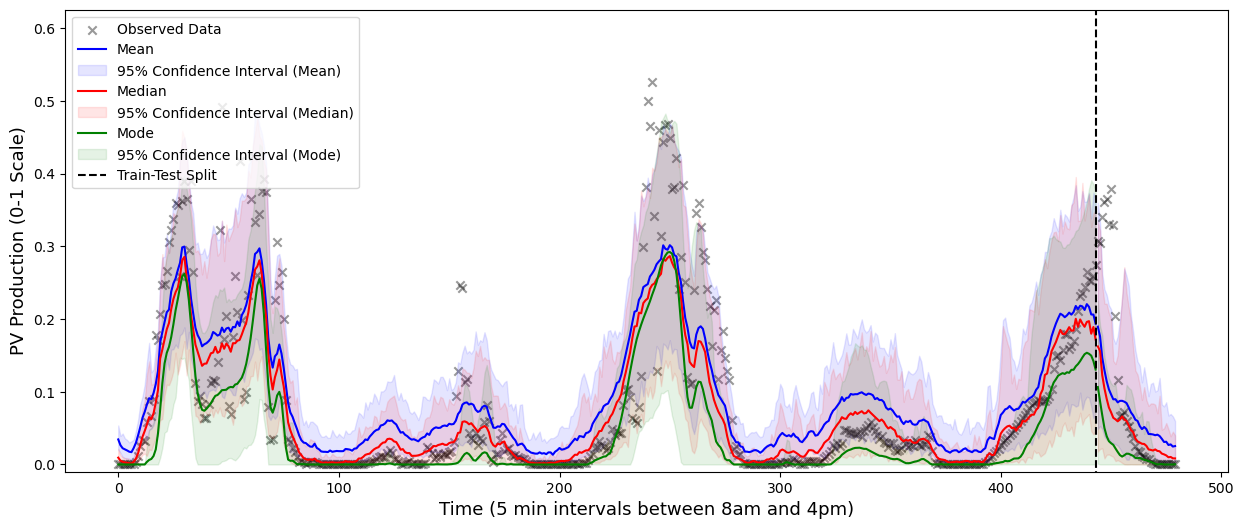

Iter 30/300 - Loss: -1.740
Iter 60/300 - Loss: -2.215
Iter 90/300 - Loss: -2.366
Iter 120/300 - Loss: -2.446
Iter 150/300 - Loss: -2.492
Iter 180/300 - Loss: -2.521
Iter 210/300 - Loss: -2.541
Iter 240/300 - Loss: -2.556
Iter 270/300 - Loss: -2.568
Iter 300/300 - Loss: -2.579


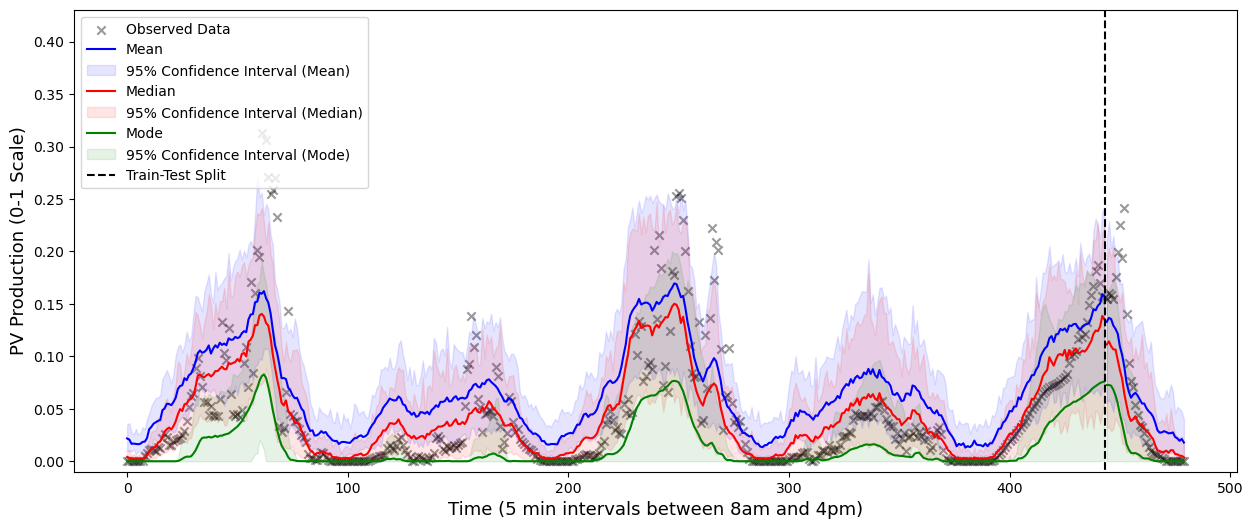

Iter 30/300 - Loss: -1.555
Iter 60/300 - Loss: -2.071
Iter 90/300 - Loss: -2.222
Iter 120/300 - Loss: -2.301
Iter 150/300 - Loss: -2.346
Iter 180/300 - Loss: -2.374
Iter 210/300 - Loss: -2.391
Iter 240/300 - Loss: -2.404
Iter 270/300 - Loss: -2.415
Iter 300/300 - Loss: -2.424


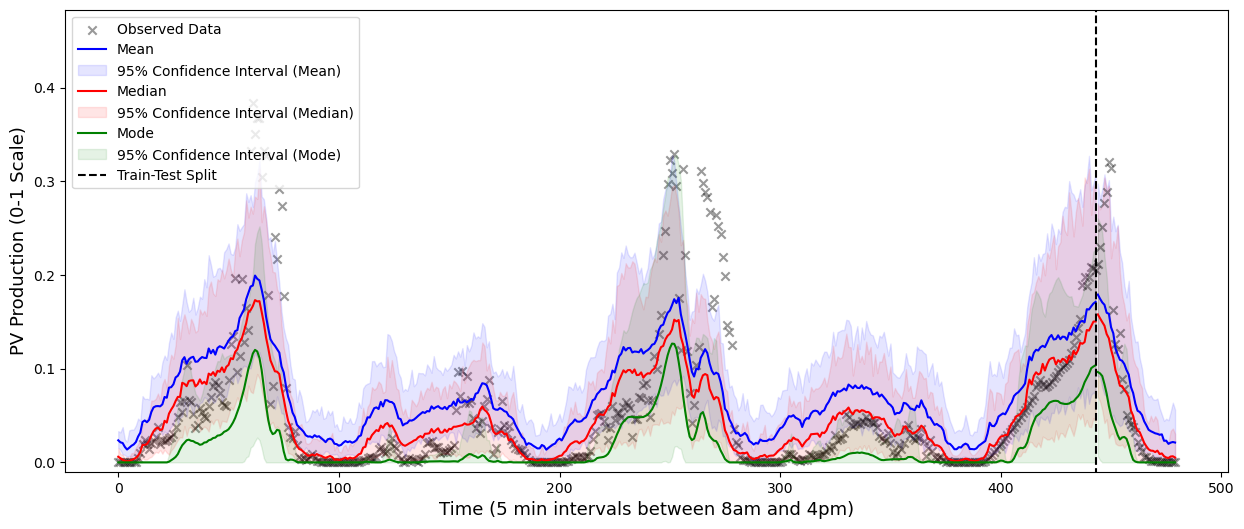

Iter 30/300 - Loss: -1.498
Iter 60/300 - Loss: -2.011
Iter 90/300 - Loss: -2.153
Iter 120/300 - Loss: -2.204
Iter 150/300 - Loss: -2.229
Iter 180/300 - Loss: -2.246
Iter 210/300 - Loss: -2.258
Iter 240/300 - Loss: -2.267
Iter 270/300 - Loss: -2.274
Iter 300/300 - Loss: -2.280


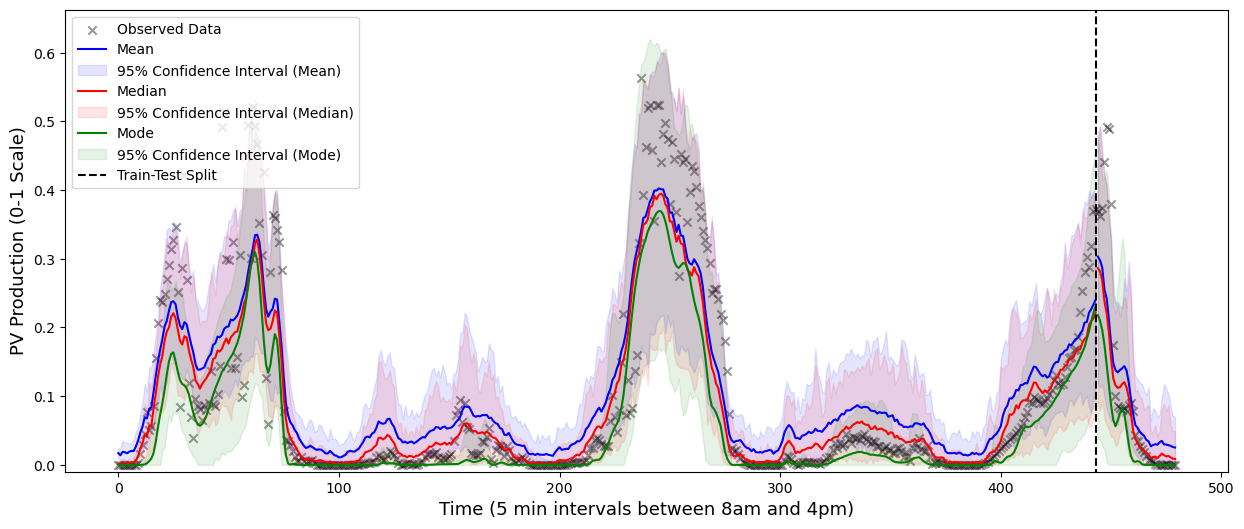

Iter 30/300 - Loss: -1.319
Iter 60/300 - Loss: -1.985
Iter 90/300 - Loss: -2.154
Iter 120/300 - Loss: -2.230
Iter 150/300 - Loss: -2.271
Iter 180/300 - Loss: -2.298
Iter 210/300 - Loss: -2.316
Iter 240/300 - Loss: -2.330
Iter 270/300 - Loss: -2.341
Iter 300/300 - Loss: -2.350


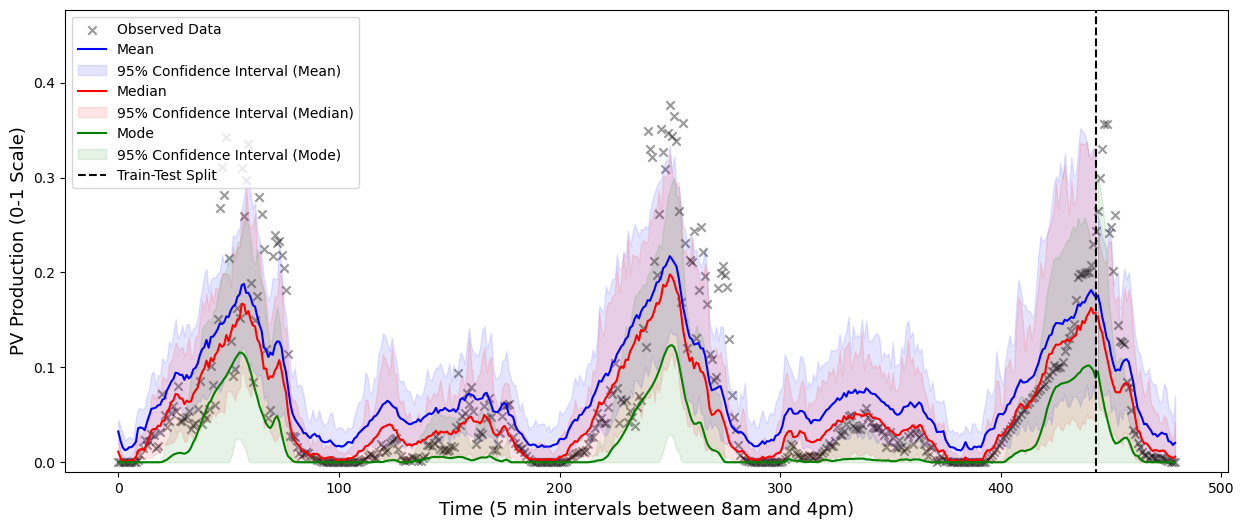

Iter 30/300 - Loss: -1.530
Iter 60/300 - Loss: -2.150
Iter 90/300 - Loss: -2.302
Iter 120/300 - Loss: -2.359
Iter 150/300 - Loss: -2.391
Iter 180/300 - Loss: -2.412
Iter 210/300 - Loss: -2.428
Iter 240/300 - Loss: -2.441
Iter 270/300 - Loss: -2.451
Iter 300/300 - Loss: -2.460


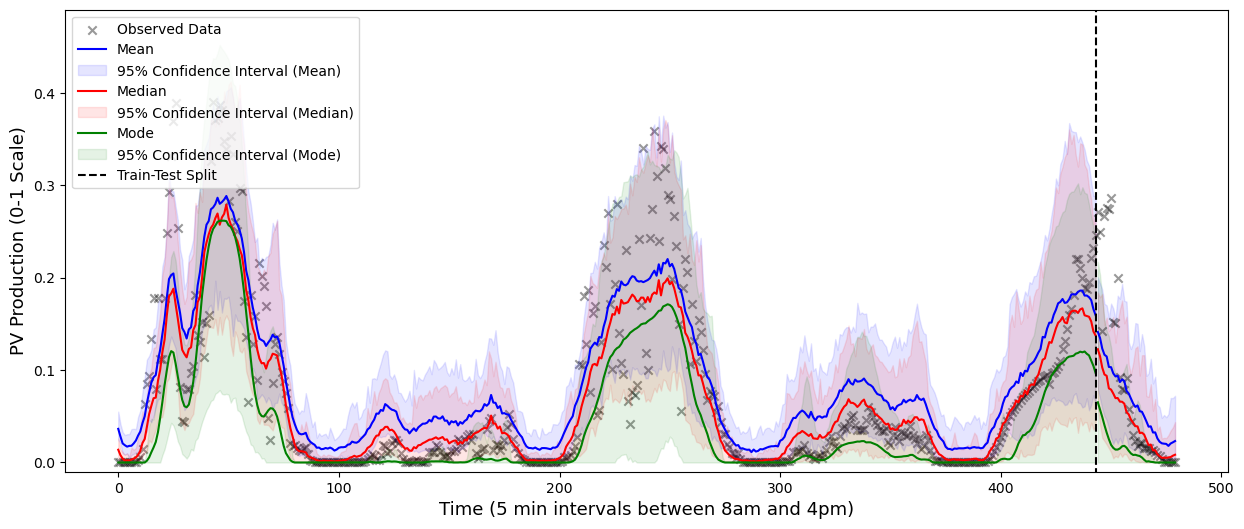

Iter 30/300 - Loss: -1.536
Iter 60/300 - Loss: -2.093
Iter 90/300 - Loss: -2.279
Iter 120/300 - Loss: -2.349
Iter 150/300 - Loss: -2.385
Iter 180/300 - Loss: -2.405
Iter 210/300 - Loss: -2.419
Iter 240/300 - Loss: -2.430
Iter 270/300 - Loss: -2.438
Iter 300/300 - Loss: -2.445


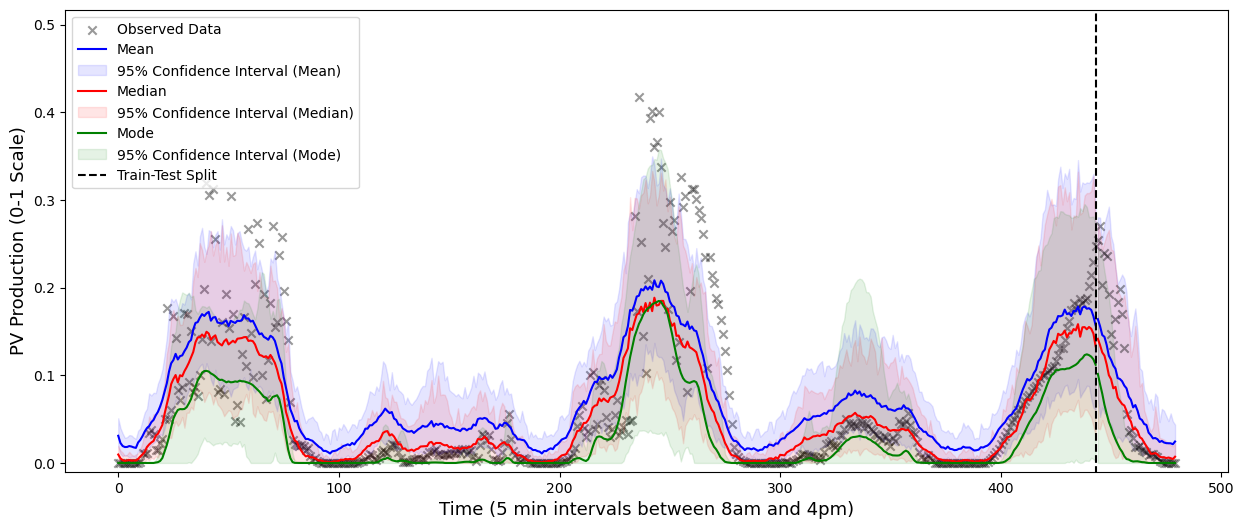

Iter 30/300 - Loss: -1.546
Iter 60/300 - Loss: -2.108
Iter 90/300 - Loss: -2.236
Iter 120/300 - Loss: -2.301
Iter 150/300 - Loss: -2.340
Iter 180/300 - Loss: -2.367
Iter 210/300 - Loss: -2.387
Iter 240/300 - Loss: -2.402
Iter 270/300 - Loss: -2.414
Iter 300/300 - Loss: -2.423


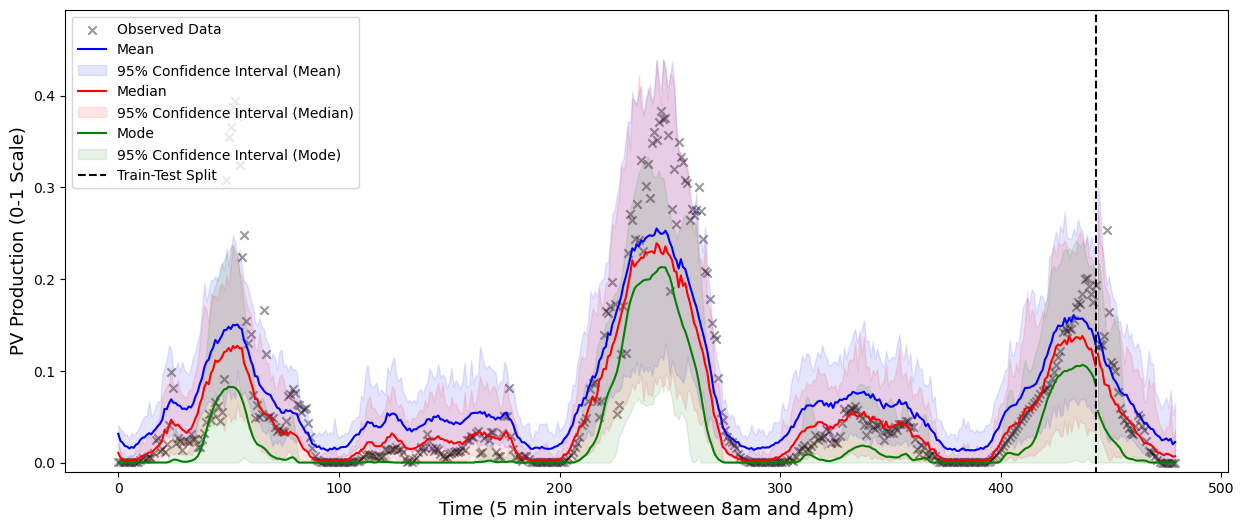

Iter 30/300 - Loss: -1.729
Iter 60/300 - Loss: -2.389
Iter 90/300 - Loss: -2.553
Iter 120/300 - Loss: -2.626
Iter 150/300 - Loss: -2.669
Iter 180/300 - Loss: -2.699
Iter 210/300 - Loss: -2.720
Iter 240/300 - Loss: -2.737
Iter 270/300 - Loss: -2.751
Iter 300/300 - Loss: -2.763


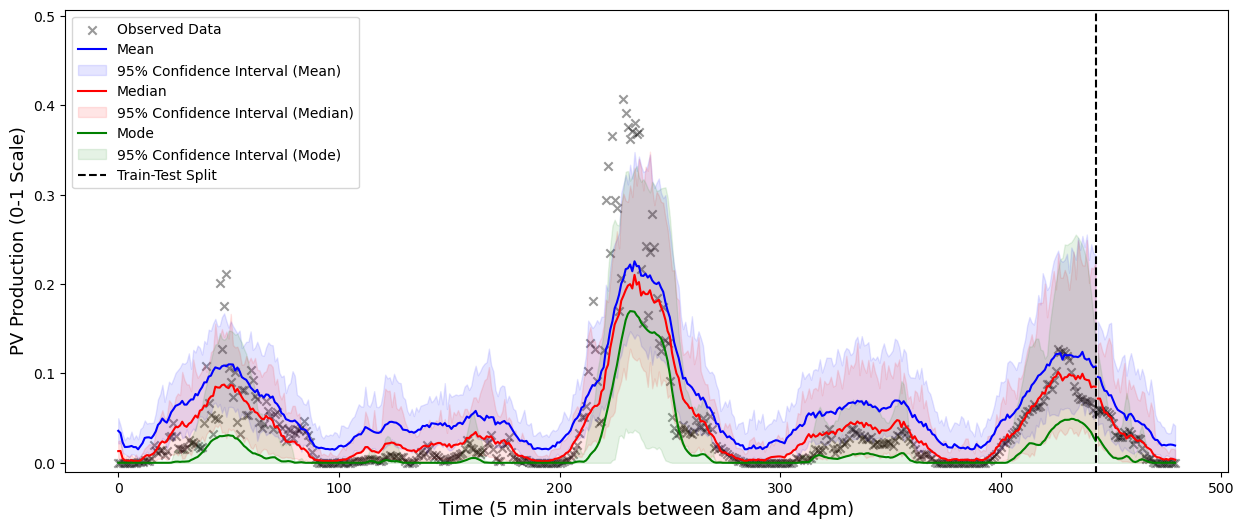

In [17]:
jitter = 1e-4
config = {  'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

for idx in range(y_train.size(1)):
    
  
    inputs_mean = { 'X': x_train, 
                    'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': quasi_periodic_matern,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=10,
                                                                     correcting_scale=1,
                                                                     lower_bound=0.10,
                                                                     upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = ApproximateGPBaseModel(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'), verbose=True)    
    
    preds = model_beta.predict(time, device=torch.device('cpu'))
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], pred_type='all')


# Hyperparameter Optimization

In [8]:
config = {'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

jitter = 1e-4

hyper_opt = HyperParameterOptimization( model='beta',
                                        x_train=x_train,
                                        y_train=y_train,
                                        x_test=x_test,
                                        y_test=y_test,
)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: hyper_opt.objective(trial, config, jitter, kernel='matern'), n_trials=10)

[I 2023-06-28 15:49:26,222] A new study created in memory with name: no-name-bddeaeaf-a966-4f94-ab59-4a13fb380c66
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 30] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 26].
  warnings.warn(
[I 2023-06-28 15:52:11,973] Trial 0 finished with value: 0.044488128274679184 and parameters: {'matern_L_shape': 2.0, 'matern_L_rate': 6.0, 'signal_matern_shape': 7.0, 'signal_matern_rate': 9.0, 'likelihood_scale': 16, 'likelihood_correcting_scale': 3.0, 'lr': 0.30000000000000004}. Best is trial 0 with value: 0.044488128274679184.
[I 2023-06-28 15:54:52,988] Trial 1 finished with value: 0.04648548364639282 and parameters: {'matern_L_shape': 1.0, 'matern_L_rate': 3.0, 'signal_matern_shape': 2.0, 'signal_matern_rate': 7.0, 'likelihood_scale': 26, 'likelihood_correcting_scale': 3.0, 'lr': 0.1}. Best is trial 0 with value:

In [8]:
from optuna.visualization import plot_optimization_history, plot_contour, plot_parallel_coordinate, plot_param_importances

In [9]:
plot_optimization_history(study)

In [12]:
plot_contour(study, params=[ 'period_P_shape', 'period__P_rate'])

In [13]:
plot_parallel_coordinate(study)

In [14]:
plot_param_importances(study)

In [15]:
best_params = study.best_params
best_params

{'matern_L_shape': 5.0,
 'matern_L_rate': 4.0,
 'signal_matern_shape': 7.0,
 'signal_matern_rate': 5.0,
 'periodic_L_shape': 5.0,
 'period_L_rate': 2.0,
 'period_P_shape': 5.0,
 'period__P_rate': 2.0,
 'signal_periodic_shape': 9.0,
 'signal_periodic_rate': 1.0,
 'likelihood_scale': 16,
 'likelihood_correcting_scale': 1.0,
 'lr': 0.1}